# **Diabetic Retinopathy Segmentation Fundus Image Data Pipeline**

In [1]:
import pandas as pd
from pathlib import Path
import numpy as np
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import albumentations as A
from albumentations import ToTensorV2
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
import cv2
import os
from sklearn.model_selection import train_test_split
import random
print("")

In [2]:
REPO_ROOT = Path("/Users/liu_michael/Documents/fundus-image-segmentation").resolve()
os.chdir(REPO_ROOT)
print("CWD set to:", Path.cwd())

CWD set to: /Users/liu_michael/Documents/fundus-image-segmentation


## **1. Create DataFrames**
Extracts the image and mask paths from the folder. All data is extracted at once into one dataframe. Train-valid-test split is done after.

In [3]:
def build_dataframe(ddr_root: str, idrid_root: str, tjdr_root: str):
    rows = []
    ddr_root = Path(ddr_root).resolve()
    idrid_root = Path(idrid_root).resolve()
    tjdr_root = Path(tjdr_root).resolve()
    # ------------------
    # DDR
    # ------------------
    for split in ["train", "valid", "test"]:
        split_root = ddr_root / split
        if not split_root.exists():
            continue
        # Map DDR "valid" → "train"
        effective_split = "train" if split == "valid" else split
        for root, _, files in os.walk(split_root):
            root = Path(root)
            for f in files:
                if f.lower().endswith(".jpg") and root.name == "image":
                    img_path = (root / f).resolve()
                    base = img_path.stem
                    label_root = root.parent / "label"

                    ex = label_root / "EX" / f"{base}.tif"
                    he = label_root / "HE" / f"{base}.tif"
                    ma = label_root / "MA" / f"{base}.tif"
                    se = label_root / "SE" / f"{base}.tif"

                    rows.append({
                        "dataset": "DDR",
                        "split": effective_split,  # <-- key line
                        "image_path": str(img_path.relative_to(REPO_ROOT)),
                        "ex_path": str(ex.relative_to(REPO_ROOT)) if ex.exists() else None,
                        "he_path": str(he.relative_to(REPO_ROOT)) if he.exists() else None,
                        "ma_path": str(ma.relative_to(REPO_ROOT)) if ma.exists() else None,
                        "se_path": str(se.relative_to(REPO_ROOT)) if se.exists() else None,
                        "tjdr_ann_path": None,
                    })
    # ------------------
    # IDRiD
    # ------------------
    for split in ["train", "test"]:
        img_dir = idrid_root / "Original_Images" / split
        if not img_dir.exists():
            continue

        mask_base = idrid_root / "Segmentation_Groundtruths" / split

        for f in img_dir.iterdir():
            if f.suffix.lower() not in [".jpg", ".png", ".jpeg", ".tif"]:
                continue
            img_path = f.resolve()
            base = img_path.stem

            ma = mask_base / "1. Microaneurysms" / f"{base}_MA.tif"
            he = mask_base / "2. Haemorrhages" / f"{base}_HE.tif"
            ex = mask_base / "3. Hard Exudates" / f"{base}_EX.tif"
            se = mask_base / "4. Soft Exudates" / f"{base}_SE.tif"

            rows.append({
                "dataset": "IDRID",
                "split": split,
                "image_path": str(img_path.relative_to(REPO_ROOT)),
                "ex_path": str(ex.relative_to(REPO_ROOT)) if ex.exists() else None,
                "he_path": str(he.relative_to(REPO_ROOT)) if he.exists() else None,
                "ma_path": str(ma.relative_to(REPO_ROOT)) if ma.exists() else None,
                "se_path": str(se.relative_to(REPO_ROOT)) if se.exists() else None,
                "tjdr_ann_path": None,
            })
    # ------------------
    # TJDR
    # ------------------
    for split in ["train", "test"]:
        img_dir = tjdr_root / split / "image"
        ann_dir = tjdr_root / split / "annotation"
        if not img_dir.exists() or not ann_dir.exists():
            continue
        for img_path in img_dir.iterdir():
            if img_path.suffix.lower() not in [".jpg", ".png", ".jpeg"]:
                continue
            ann_path = ann_dir / f"{img_path.stem}.png"
            if not ann_path.exists():
                continue

            rows.append({
                "dataset": "TJDR",
                "split": split,
                "image_path": str(img_path.relative_to(REPO_ROOT)),
                "ex_path": None,
                "he_path": None,
                "ma_path": None,
                "se_path": None,
                "tjdr_ann_path": str(ann_path.relative_to(REPO_ROOT)),
            })
    return pd.DataFrame(rows)

df = build_dataframe(
    ddr_root = "DDR-SEGMENTATION",
    idrid_root = "IDRID",
    tjdr_root = "TJDR",
)

In [4]:
df.isna().sum()

dataset            0
split              0
image_path         0
ex_path          561
he_path          562
ma_path          561
se_path          602
tjdr_ann_path    838
dtype: int64

In [5]:
df.groupby("dataset").count()

,split,image_path,ex_path,he_path,ma_path,se_path,tjdr_ann_path
dataset,,,,,,,
DDR,757,757,757,757,757,757,0
IDRID,81,81,81,80,81,40,0
TJDR,561,561,0,0,0,0,561


In [6]:
df.shape

(1399, 8)

In [7]:
df.sample(2)

,dataset,split,image_path,ex_path,he_path,ma_path,se_path,tjdr_ann_path
230,DDR,train,DDR-SEGMENTATION/train/image/007-3520-200.jpg,DDR-SEGMENTATION/train/label/EX/007-3520-200.tif,DDR-SEGMENTATION/train/label/HE/007-3520-200.tif,DDR-SEGMENTATION/train/label/MA/007-3520-200.tif,DDR-SEGMENTATION/train/label/SE/007-3520-200.tif,None
72,DDR,train,DDR-SEGMENTATION/train/image/007-2366-100.jpg,DDR-SEGMENTATION/train/label/EX/007-2366-100.tif,DDR-SEGMENTATION/train/label/HE/007-2366-100.tif,DDR-SEGMENTATION/train/label/MA/007-2366-100.tif,DDR-SEGMENTATION/train/label/SE/007-2366-100.tif,None


In [8]:
# Split the dataframe for testing, validation and training
train_df = df[df.split == "train"].reset_index(drop = True)
test_df  = df[df.split == "test"].reset_index(drop = True)

train_df, val_df = train_test_split(
    df[df.split == "train"],
    test_size = 0.2,
    random_state = 42,
    stratify = df[df.split == "train"]["dataset"]
)

train_df = train_df.reset_index(drop = True)
val_df   = val_df.reset_index(drop = True)
test_df  = test_df.reset_index(drop = True)

In [9]:
assert train_df["image_path"].is_unique
assert val_df["image_path"].is_unique
assert test_df["image_path"].is_unique

assert set(train_df.columns) == set(val_df.columns) == set(test_df.columns)

In [10]:
counts = pd.concat(
    {
        "train": train_df["dataset"].value_counts(),
        "val":   val_df["dataset"].value_counts(),
        "test":  test_df["dataset"].value_counts(),
    },
    axis = 1
).fillna(0).astype(int)

counts

,train,val,test
dataset,,,
DDR,426,106,225
TJDR,358,90,113
IDRID,43,11,27


In [11]:
DATA_DIR = Path("data_csv")
DATA_DIR.mkdir(exist_ok = True)

train_df.to_csv(DATA_DIR / "train_df.csv", index = False)
val_df.to_csv(DATA_DIR / "val_df.csv", index = False)
test_df.to_csv(DATA_DIR / "test_df.csv", index = False)

In [12]:
len(train_df), len(val_df), len(test_df)

(827, 207, 365)

## **2. Dataset and Augmentation Definitions**

In [13]:
def center_crop_largest_square(image, **kwargs):
    h, w = image.shape[:2]
    min_dim = min(h, w)
    top = (h - min_dim) // 2
    left = (w - min_dim) // 2
    return image[top : top + min_dim, left:left + min_dim]

In [ ]:
def apply_clahe(
    image_rgb,
    clip_limit = 2.5,
    tile_grid_size = (8, 8),
    mode = "lab"   # "lab" or "green" or "casp"
):
    clahe = cv2.createCLAHE(
        clipLimit = clip_limit,
        tileGridSize = tile_grid_size
    )

    if mode == "lab":
        lab = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2LAB)
        l, a, b = cv2.split(lab)
        l = clahe.apply(l)
        lab = cv2.merge((l, a, b))
        return cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)

    elif mode == "green":
        out = image_rgb.copy()
        out[:, :, 1] = clahe.apply(out[:, :, 1])
        return out
    
    elif mode == "casp":
        out = image_rgb.copy()

        # --- Green channel: CLAHE ---
        out[:, :, 1] = clahe.apply(out[:, :, 1])

        # --- Red & Blue: light stabilization ---
        for c in [0, 2]:  # Red, Blue
            channel = out[:, :, c]

            # light blur (noise suppression)
            channel = cv2.GaussianBlur(channel, ksize = (3, 3), sigmaX = 0)
            # min–max normalization (avoid division by zero)
            min_val = channel.min()
            max_val = channel.max()
            if max_val > min_val:
                channel = ((channel - min_val) / (max_val - min_val) * 255).astype(channel.dtype)

            out[:, :, c] = channel

        return out
    else:
        raise ValueError("mode must be 'lab', 'green', or 'casp'")


In [15]:
class CLAHETransform(A.ImageOnlyTransform):
    def __init__(self, dataset):
        super().__init__(p = 1.0)
        self.dataset = dataset

    def apply(self, image, **params):
        if not self.dataset.use_clahe:
            return image

        return apply_clahe(
            image,
            clip_limit = self.dataset.clahe_clip,
            tile_grid_size = self.dataset.clahe_tile,
            mode = self.dataset.clahe_mode
        )

In [16]:
class FundusSegmentationDataset(Dataset):
    """
    Fundus Dataset
    - Center crop largest square
    - Resize to (dimensions, dimensions)

    image: (3, H, W)
    masks: (4, H, W)  # EX, HE, MA, SE
    """

    CLASSES = ["EX", "HE", "MA", "SE"]
    MASK_COLUMNS = {
        "EX": "ex_path",
        "HE": "he_path",
        "MA": "ma_path",
        "SE": "se_path",
    }

    def __init__(
        self,
        df: pd.DataFrame,
        dimensions: int = 512,
        transform_type = "train",
        use_clahe: bool = False,
        clahe_clip: float = 2.5,
        clahe_tile: tuple = (8, 8),
        clahe_mode: str = "lab",
    ):
        self.df = df.reset_index(drop = True)
        self.dimensions = dimensions
        self.transform_type = transform_type

        self.use_clahe = use_clahe
        self.clahe_clip = float(clahe_clip)
        self.clahe_tile = clahe_tile
        self.clahe_mode = clahe_mode

        self.transforms = self._build_transforms()

    def _build_transforms(self):
        transforms = [
            A.Lambda(
                image = center_crop_largest_square,
                mask = center_crop_largest_square
            ),
            A.Resize(self.dimensions, self.dimensions),
            CLAHETransform(self),
        ]

        if self.transform_type == "train":
            transforms.extend(
                [
                    A.HorizontalFlip(p = 0.5),
                    A.VerticalFlip(p = 0.5),
                    A.Affine(
                    translate_percent = 0.08,
                    scale = (0.88, 1.12),
                    rotate = (-15, 15),
                    border_mode = cv2.BORDER_CONSTANT,
                    fill = 0,
                    fill_mask = 0,
                    p = 0.7,
                )
                ]
            )

        return A.Compose(
            transforms,
            additional_targets = {
                "mask1": "mask",
                "mask2": "mask",
                "mask3": "mask",
                "mask4": "mask",
            },
            is_check_shapes = False,
        )

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        row = self.df.loc[index]

        # ================= Image =================
        image = cv2.imread(row.image_path, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # ================= Masks =================
        if row.dataset == "TJDR":
            # ---- TJDR: color-coded single annotation ----
            ann = cv2.imread(row.tjdr_ann_path, cv2.IMREAD_COLOR)
            ann = cv2.cvtColor(ann, cv2.COLOR_BGR2RGB)

            r, g, b = ann[..., 0], ann[..., 1], ann[..., 2]

            masks = [
                ((r == 128)   & (g == 0)   & (b == 0)).astype(np.uint8),  # EX (red)
                ((r == 0)   & (g == 128) & (b == 0)).astype(np.uint8),  # HE (green)
                ((r == 128) & (g == 128) & (b == 0)).astype(np.uint8),    # MA (yellow)
                ((r == 0) & (g == 0)   & (b == 128)).astype(np.uint8),    # SE (blue)
            ]

        else:
            # ---- DDR / IDRiD: per-class binary masks ----
            masks = []
            for cls in self.CLASSES:
                path = getattr(row, self.MASK_COLUMNS[cls])

                if pd.isna(path):
                    h, w = image.shape[:2]
                    mask = np.zeros((h, w), dtype = np.uint8)
                else:
                    mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                    mask = (mask > 0).astype(np.uint8)

                masks.append(mask)

        # ================= Transforms =================
        data = self.transforms(
            image = image,
            mask1 = masks[0],  # EX
            mask2 = masks[1],  # HE
            mask3 = masks[2],  # MA
            mask4 = masks[3],  # SE
        )

        image = torch.from_numpy(data["image"]).permute(2, 0, 1).float() / 255.0
        masks = torch.stack(
            [torch.from_numpy(data[f"mask{i+1}"]) for i in range(4)]
        ).float()

        return image, masks


## **3. DataLoaders**

In [17]:
def build_fundus_train_dataset(
    df,
    dimensions,
    use_clahe = False,
    clahe_clip = 2.5,
    clahe_tile = (8, 8),
    clahe_mode = "lab",
):
    return FundusSegmentationDataset(
        df,
        dimensions = dimensions,
        transform_type = "train",
        use_clahe = use_clahe,
        clahe_clip = clahe_clip,
        clahe_tile = clahe_tile,
        clahe_mode = clahe_mode,
    )

def build_fundus_eval_dataset(
    df,
    dimensions,
    use_clahe = False,
    clahe_clip = 2.5,
    clahe_tile = (8, 8),
    clahe_mode = "lab",
):
    return FundusSegmentationDataset(
        df,
        dimensions = dimensions,
        transform_type = "eval",
        use_clahe = use_clahe,
        clahe_clip = clahe_clip,
        clahe_tile = clahe_tile,
        clahe_mode = clahe_mode,
    )


In [26]:
train_ds = build_fundus_train_dataset(train_df, 512, True, 2.0, (8, 8), "green")
val_ds = build_fundus_eval_dataset(val_df, 512, True, 2.0, (8, 8), "green") 
test_ds = build_fundus_eval_dataset(test_df, 512, True, 2.0, (8, 8), "green")

In [27]:
# Build DataLoaders
def build_train_loader(dataset, batch_size, shuffle = False):
    """
    Training loader.
    """
    return DataLoader(
        dataset,
        batch_size = batch_size,
        shuffle = shuffle,
        num_workers = 0,
        pin_memory = True
    )

def build_eval_loader(dataset, batch_size):
    """
    Validation / Test loader.
    """
    return DataLoader(
        dataset,
        batch_size = batch_size,
        shuffle = False,
        num_workers = 0,
        pin_memory = True
    )


# ---- Train loaders ----
train_loader = build_train_loader(train_ds, 16, False)
val_loader = build_eval_loader(val_ds, 16)
test_loader = build_eval_loader(test_ds, 16)

In [28]:
len(train_loader), len(val_loader), len(test_loader)

(52, 13, 23)

## **4. Visualizations**

In [29]:
# RGB colors for each mask channel
COLOR_MAP = {
    0: (255, 38, 190),          # EX -> pink
    1: (17, 255, 0),          # HE -> green
    2: (232, 252, 3),          # MA -> yellow
    3: (43, 206, 255),             # SE -> blue
}

CLASS_NAMES = ["EX", "HE", "MA", "SE"]

In [33]:
def visualize_sample(dataset, index = 0, alpha = 0.8):
    plt.rcParams["font.family"] = "Serif"
    plt.rcParams["font.weight"] = "bold"
    plt.rcParams["axes.titleweight"] = "bold"

    # ---- Load sample ----
    img, masks = dataset[index]  # img: (3, H, W), masks: (C, H, W)

    # Move to CPU just in case
    img = img.detach().cpu()
    masks = masks.detach().cpu()

    img_np = img.permute(1, 2, 0).numpy()

    # ---- APPLY CLAHE (LAB) FOR VISUALIZATION ONLY ----
    img_np = (img_np * 255).astype(np.uint8)
    img_np = apply_clahe(
        img_np,
        clip_limit = 2.5,
        tile_grid_size = (8, 8),
        mode = "lab"
    )
    img_np = img_np.astype(np.float32) / 255.0
    # -----------------------------------------------

    num_classes = masks.shape[0]

    fig, axes = plt.subplots(1, 2, figsize = (12, 6))

    # ================= Left: Image =================
    axes[0].imshow(img_np)
    axes[0].set_title("CLAHE (Green Channel) Image", fontsize = 22)
    axes[0].axis("off")

    # ================= Right: Image + Mask Overlay =================
    axes[1].imshow(img_np)

    for i in range(num_classes):
        mask = masks[i].numpy()
        if mask.max() == 0:
            continue

        colored_mask = np.zeros((*mask.shape, 4))
        color = np.array(COLOR_MAP[i]) / 255.0

        colored_mask[..., :3] = color
        colored_mask[..., 3] = mask * alpha

        axes[1].imshow(colored_mask)

    axes[1].set_title("CLAHE Image + Mask Overlay", fontsize = 22)
    axes[1].axis("off")

    # ================= Legend =================
    legend_elements = [
        plt.Line2D(
            [0], [0],
            marker = "o",
            color = "w",
            markerfacecolor = np.array(COLOR_MAP[i]) / 255.0,
            markersize = 16,
            label = CLASS_NAMES[i],
        )
        for i in range(num_classes)
    ]

    fig.legend(
        handles = legend_elements,
        loc = "lower center",
        ncol = num_classes,
        frameon = False,
        fontsize = 14,
        bbox_to_anchor = (0.5, -0.05),
    )

    plt.tight_layout()
    plt.show()


In [128]:
i -= 1

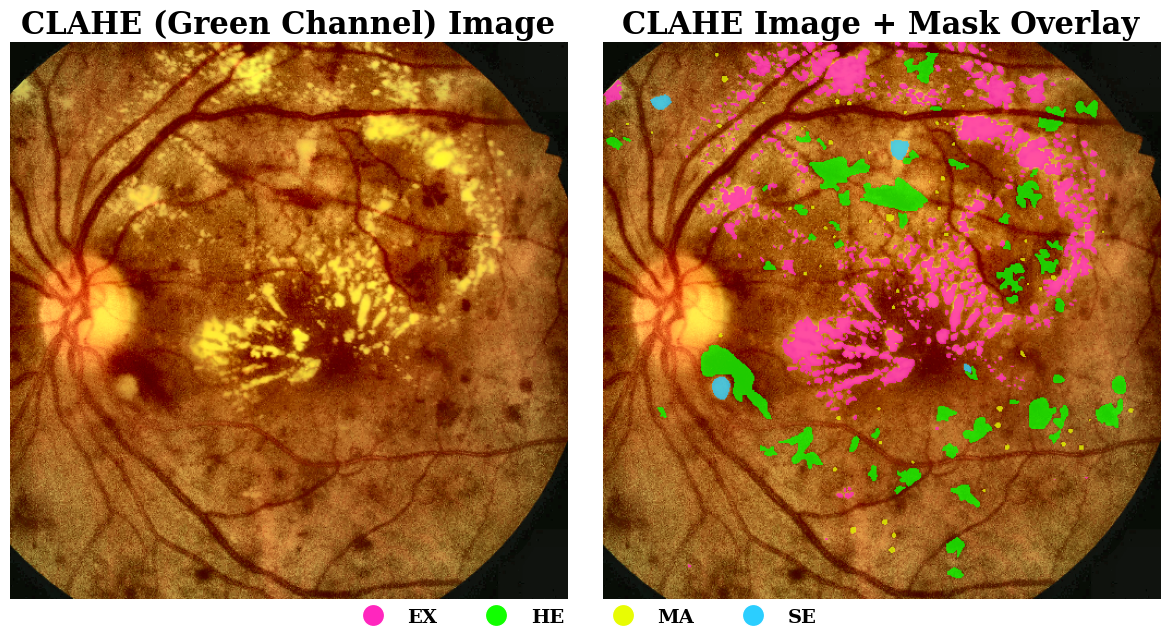

In [136]:
visualize_sample(train_ds, index = i)

In [127]:
#def plot_class_pixel_distribution_from_csv(df):
    """
    Pixel-level lesion class distribution after the SAME preprocessing
    used during training:
      - center crop largest square
      - resize to 512x512 (nearest neighbor)

    Background excluded.

    Left: IDRiD
    Middle: DDR
    Right: TJDR
    """

    TARGET_H = 512
    TARGET_W = 512

    CLASSES = ["EX", "HE", "MA", "SE"]

    class_to_col = {
        "EX": "ex_path",
        "HE": "he_path",
        "MA": "ma_path",
        "SE": "se_path",
    }

    def center_crop_largest_square_mask(arr):
        """
        Center-crop largest square.
        Works for both:
        - 2D arrays (H, W)
        - 3D arrays (H, W, C)
        """
        h, w = arr.shape[:2]
        size = min(h, w)
        y0 = (h - size) // 2
        x0 = (w - size) // 2
        return arr[y0:y0 + size, x0:x0 + size]


    def count_pixels_binary(sub_df):
        """For DDR / IDRiD"""
        pixel_counts = {cls: 0 for cls in CLASSES}

        for _, row in sub_df.iterrows():
            for cls in CLASSES:
                path = row[class_to_col[cls]]
                if pd.isna(path):
                    continue

                mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                if mask is None:
                    continue

                mask = center_crop_largest_square_mask(mask)
                mask = cv2.resize(
                    mask,
                    (TARGET_W, TARGET_H),
                    interpolation = cv2.INTER_NEAREST,
                )

                pixel_counts[cls] += int((mask > 0).sum())

        return pixel_counts

    def count_pixels_tjdr(sub_df):
        """For TJDR color-coded annotations"""
        pixel_counts = {cls: 0 for cls in CLASSES}

        for _, row in sub_df.iterrows():
            ann = cv2.imread(row.tjdr_ann_path, cv2.IMREAD_COLOR)
            if ann is None:
                continue

            ann = cv2.cvtColor(ann, cv2.COLOR_BGR2RGB)
            ann = center_crop_largest_square_mask(ann)
            ann = cv2.resize(
                ann,
                (TARGET_W, TARGET_H),
                interpolation = cv2.INTER_NEAREST,
            )

            r, g, b = ann[..., 0], ann[..., 1], ann[..., 2]

            pixel_counts["EX"] += int(((r == 128)   & (g == 0)   & (b == 0)).sum())
            pixel_counts["HE"] += int(((r == 0)   & (g == 128) & (b == 0)).sum())
            pixel_counts["MA"] += int(((r == 128) & (g == 128) & (b == 0)).sum())
            pixel_counts["SE"] += int(((r == 0) & (g == 0)   & (b == 128)).sum())

        return pixel_counts

    # ================= split datasets =================
    idrid_df = df[df["dataset"] == "IDRID"]
    ddr_df   = df[df["dataset"] == "DDR"]
    tjdr_df  = df[df["dataset"] == "TJDR"]

    idrid_counts = count_pixels_binary(idrid_df)
    ddr_counts   = count_pixels_binary(ddr_df)
    tjdr_counts  = count_pixels_tjdr(tjdr_df)

    # Safety check
    assert set(CLASSES) == set(CLASS_NAMES)

    colors = [np.array(COLOR_MAP[CLASS_NAMES.index(k)]) / 255.0 for k in CLASSES]

    fig, axes = plt.subplots(1, 3, figsize = (20, 7))

    # ================= IDRiD =================
    axes[0].pie(
        [idrid_counts[k] for k in CLASSES],
        labels = CLASSES,
        colors = colors,
        autopct = "%1.1f%%",
        startangle = 90,
        counterclock = False,
        textprops = {"fontsize": 14, "weight": "bold"},
        wedgeprops = {"edgecolor": "black"},
    )
    axes[0].set_title("IDRiD Lesion Pixel Distribution", fontsize = 18, fontweight = "bold")

    # ================= DDR =================
    axes[1].pie(
        [ddr_counts[k] for k in CLASSES],
        labels = CLASSES,
        colors = colors,
        autopct = "%1.1f%%",
        startangle = 90,
        counterclock = False,
        textprops = {"fontsize": 14, "weight": "bold"},
        wedgeprops = {"edgecolor": "black"},
    )
    axes[1].set_title("DDR Lesion Pixel Distribution", fontsize = 18, fontweight = "bold")

    # ================= TJDR =================
    axes[2].pie(
        [tjdr_counts[k] for k in CLASSES],
        labels = CLASSES,
        colors = colors,
        autopct = "%1.1f%%",
        startangle = 90,
        counterclock = False,
        textprops = {"fontsize": 14, "weight": "bold"},
        wedgeprops = {"edgecolor": "black"},
    )
    axes[2].set_title("TJDR Lesion Pixel Distribution", fontsize = 18, fontweight = "bold")

    plt.tight_layout()
    plt.show()


plot_class_pixel_distribution_from_csv(df)

IndentationError: unexpected indent (2402705159.py, line 2)

In [ ]:
#def count_tjdr_class_presence(df: pd.DataFrame):
    # Only TJDR rows
    tjdr_df = df[df["tjdr_ann_path"].notna()]

    counts = {
        "EX": 0,
        "HE": 0,
        "MA": 0,
        "SE": 0,
    }

    for _, row in tjdr_df.iterrows():
        ann = cv2.imread(row.tjdr_ann_path, cv2.IMREAD_COLOR)
        ann = cv2.cvtColor(ann, cv2.COLOR_BGR2RGB)

        r, g, b = ann[..., 0], ann[..., 1], ann[..., 2]

        has_ex = np.any((r == 0)   & (g == 0)   & (b == 128))
        has_he = np.any((r == 0)   & (g == 128) & (b == 0))
        has_ma = np.any((r == 128) & (g == 128) & (b == 0))
        has_se = np.any((r == 128) & (g == 0)   & (b == 0))

        counts["EX"] += int(has_ex)
        counts["HE"] += int(has_he)
        counts["MA"] += int(has_ma)
        counts["SE"] += int(has_se)

    return counts

counts = count_tjdr_class_presence(df)

plt.figure(figsize = (6, 4))
plt.bar(counts.keys(), counts.values())
plt.ylabel("Number of TJDR images containing class")
plt.title("TJDR: Per-Class Sample Presence")
plt.grid(axis = "y", alpha = 0.3)
plt.show()